# PreProcessing Demonstration

In this notebook, we will explore the PyTorch Dataset class and show how it can be used to handle input images. It should do some light preprocessing to make sure everything is available. 

Some things to note:
* checks to see that there is a 1-to-1 correspondence between the datasets
* does the tiling
* exports tiles that are extra

In [1]:
# Helpful trick for loading the directories correction
import sys, os
from pyprojroot import here
# spyder up to find the root
root = here(project_files=[".here"])
# append to path
sys.path.append(str(here()))


from src.data.worldfloods.dataset import WorldFloodsDataset

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

## Load Demo Image

For this demonstration, we need a S2 AND a groundtruth image. We have two that we can download.

In [2]:
from src.data.worldfloods.dataset import WorldFloodsImage
from src.data.worldfloods.download import download_image, get_image_path
from src.data.utils import download_data_from_bucket
from pathlib import Path

gs_index = "gs://"
bucket_id = "ml4floods"
path = "worldfloods/public/"
sub_dir = "train/S2"
file_name = "01042016_Holmes_Creek_at_Vernon_FL.tif"


# ============
# DATAIMAGE
# ============

# filename
file_name = "ml4floods/worldfloods/public/train/S2/01042016_Holmes_Creek_at_Vernon_FL.tif"

# initialize the dataclass (specific to the worldfloods images)
dc_image_example = WorldFloodsImage(filename=file_name)

# to see
print(dc_image_example)

# download image from bucket
destination_dir = Path(root).joinpath("datasets/trials/image/S2")
download_image(dc_image_example, destination_dir)


# ============
# GROUND TRUTH IMAGE
# ============

# filename
file_name = "ml4floods/worldfloods/public/train/gt/01042016_Holmes_Creek_at_Vernon_FL.tif"

# initialize the dataclass (specific to the worldfloods images)
dc_gt_example = WorldFloodsImage(filename=file_name)
print(dc_gt_example)

# download image from bucket
destination_dir = Path(root).joinpath("datasets/trials/image/gt")
download_image(dc_gt_example, destination_dir)

WorldFloodsImage(filename='ml4floods/worldfloods/public/train/S2/01042016_Holmes_Creek_at_Vernon_FL.tif', uri=None, filepath=None, bucket_id=None, product_id=None, load_date=datetime.datetime(2021, 2, 19, 18, 31, 47, 487381), source_system='Not Specified')
Folder '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/S2' Is Already There.
WorldFloodsImage(filename='ml4floods/worldfloods/public/train/gt/01042016_Holmes_Creek_at_Vernon_FL.tif', uri=None, filepath=None, bucket_id=None, product_id=None, load_date=datetime.datetime(2021, 2, 19, 18, 31, 47, 487381), source_system='Not Specified')
Folder '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/gt' Is Already There.


In [4]:
!ls $destination_dir

01042016_Holmes_Creek_at_Vernon_FL.tif


## Outline the Immediate Steps

* check for file correspondence between the directories

## Initialize PyTorch Dataset

In [5]:
destination_dir = Path(root).joinpath("datasets/trials/image/gt/")

image_files = [
    str(Path(root).joinpath(destination_dir).joinpath("01042016_Holmes_Creek_at_Vernon_FL.tif")),
]

train_dataset = WorldFloodsDataset(
    image_files=image_files, image_prefix="S2", gt_prefix="gt"
)
type(train_dataset)

src.data.worldfloods.dataset.WorldFloodsDataset

In [7]:
import rasterio

with rasterio.open("/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/S2/01042016_Holmes_Creek_at_Vernon_FL.tif",) as f:
    print(f)

<open DatasetReader name='/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/S2/01042016_Holmes_Creek_at_Vernon_FL.tif' mode='r'>


In [8]:
!ls /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/S2/
!ls /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/gt/

01042016_Holmes_Creek_at_Vernon_FL.tif
01042016_Holmes_Creek_at_Vernon_FL.tif


In [9]:
t = train_dataset[0]
t["image"].shape

/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/gt/01042016_Holmes_Creek_at_Vernon_FL.tif


(1, 1980, 2841)

## 1 - Open Image

First, we can access the rasterio dataset and get access to some of the attributes. The most important one for now is the `height` and `width`.

**Source**: [StackOverFlow](https://gis.stackexchange.com/questions/285499/how-to-split-multiband-image-into-image-tiles-using-rasterio)

In [10]:
with rasterio.open("gs://"+get_image_path(dc_gt_example)) as dataset:
    print(dataset)
    print(type(dataset))
    print(f"Height: {dataset.meta['height']}")
    print(f"Width: {dataset.meta['width']}")

<open DatasetReader name='gs://ml4floods/worldfloods/public/train/gt/01042016_Holmes_Creek_at_Vernon_FL.tif' mode='r'>
<class 'rasterio.io.DatasetReader'>
Height: 1980
Width: 2841


### Visualize Image

We can use the tried and true rasterio.

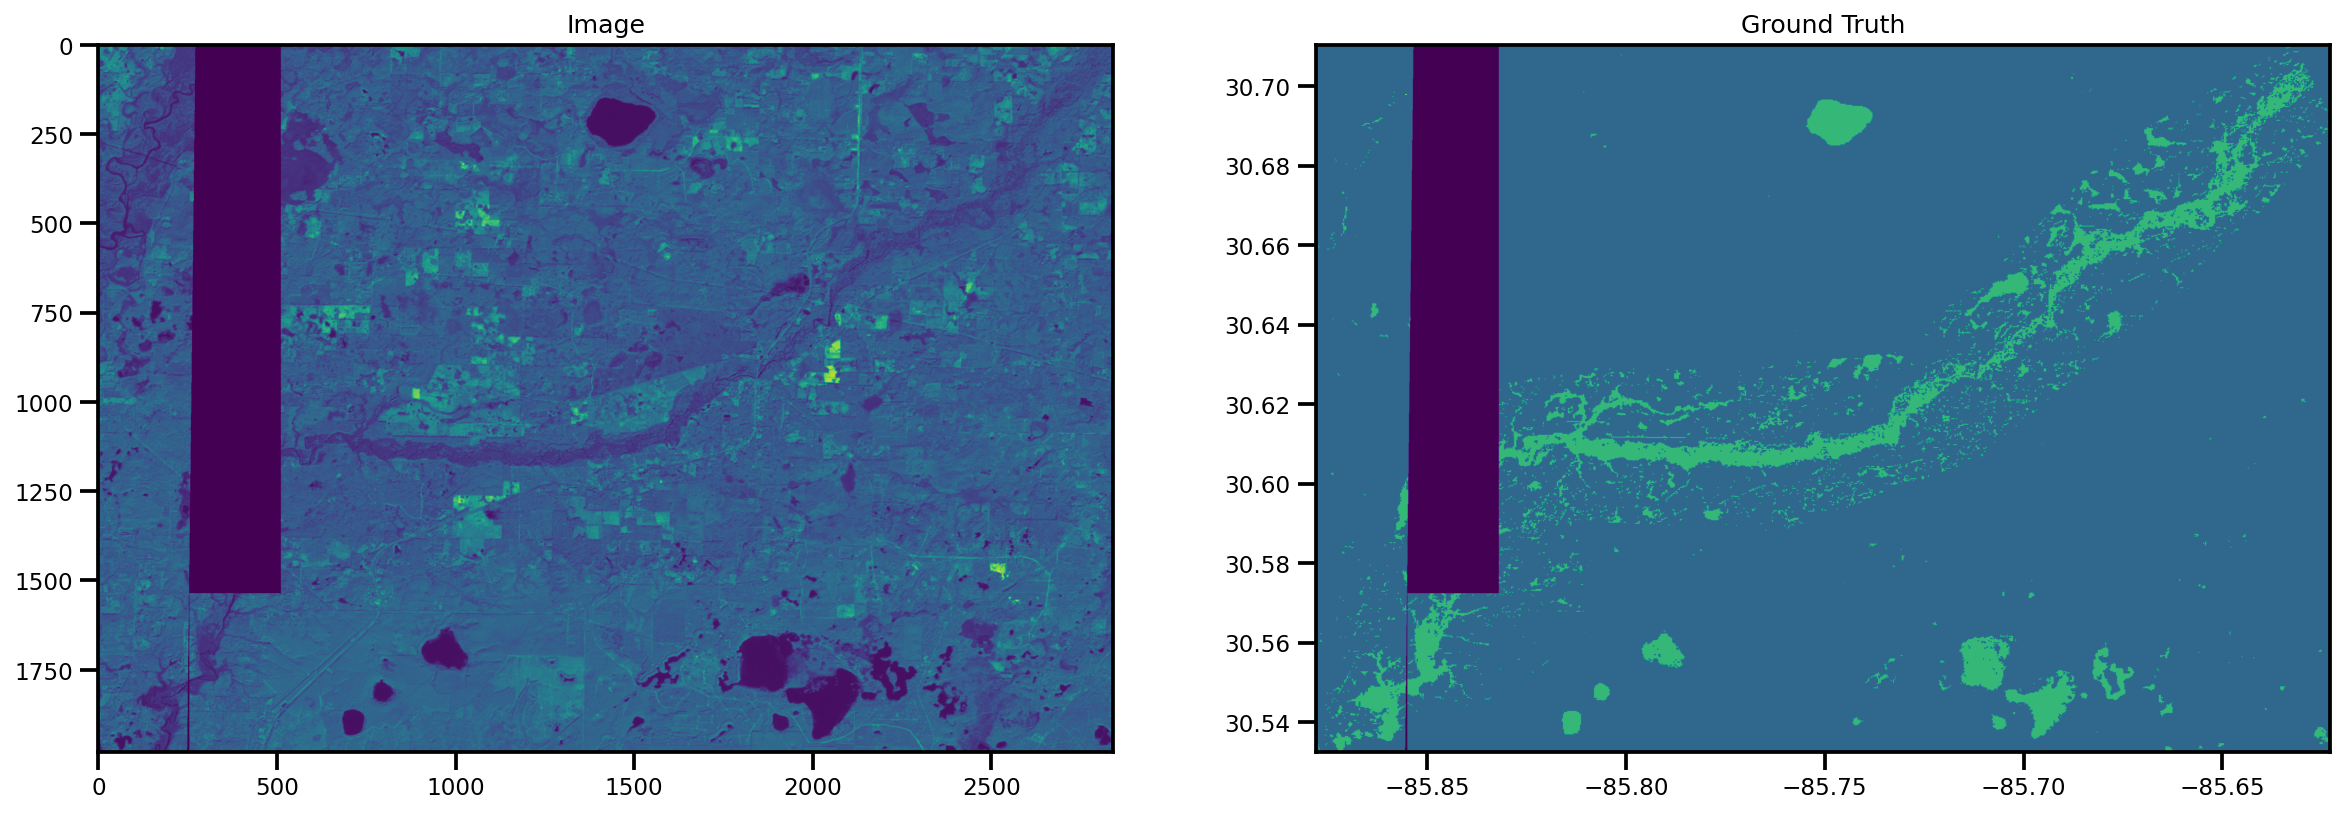

In [11]:
from rasterio.plot import show as rasterio_show

band = 6 # it shows better land features

fig, ax = plt.subplots(ncols=2, figsize=(20,10))
with rasterio.open("gs://"+get_image_path(dc_image_example)) as dataset:
    rasterio_show(
        dataset.read(indexes=band), ax=ax[0],)
    ax[0].set_title("Image",)

with rasterio.open("gs://"+get_image_path(dc_gt_example)) as dataset:
    rasterio_show(dataset, ax=ax[1])
    ax[1].set_title("Ground Truth",)
    
plt.show()

## Tiling

For ML, often we want to use a subset of the original image, aka tiles. For our purposes, we're going to be tiling indiscriminantly, i.e. we are not concerned about geocoordinates. All we care about is that the windowsize is smaller then the images.

In [108]:
# import os
# import random
# from dataclasses import dataclass, field
# from datetime import datetime
# from pathlib import Path
# from typing import Callable, Dict, List, Optional, Tuple

# import numpy as np
# import rasterio
# import rasterio.windows
# from torch.utils.data import Dataset

# from src.data.utils import check_path_exists
# from src.data.worldfloods.configs import CHANNELS_CONFIGURATIONS
# from src.data.worldfloods.prepare_data import prepare_data_func
# from src.preprocess.utils import get_list_of_window_slices

# window_size = WindowSize(height=128, width=128)


# @dataclass
# class WorldFloodsImage:
#     # ESSENTIAL METADATA
#     filename: str
#     uri: str = field(default=None)
#     filepath: str = field(default=None)
#     bucket_id: str = field(default=None)
#     product_id: str = field(default=None)

#     # BREADCRUMBS
#     load_date: str = field(default=datetime.now())
#     viewed_by: list = field(default_factory=list, compare=False, repr=False)
#     source_system: str = field(default="Not Specified")


# class WorldFloodsDatasetTiled(Dataset):
#     """
#     A dataloader for the WorldFloods dataset.

#     Attributes
#     ----------
#     window_size: tuple(int, int)
#             size of the tiling window
#     image_prefix: str
#             the subdirectory name for the images
#     gt_prefix: str
#             the subdirectory name for the groundtruth

#     """

#     def __init__(
#         self,
#         image_files: List[str],
#         image_prefix: str = "/image_files/",
#         gt_prefix: str = "/gt_files/",
#         window_size: WindowSize=WindowSize(height=128, width=128),
#         transforms: Optional[List[Callable]]=None
#     ) -> None:

#         self.image_files = image_files
#         self.image_prefix = image_prefix
#         self.gt_prefix = gt_prefix
#         self.transforms = transforms
#         self.window_size = window_size


#         # sort to make sure that the order is deterministic
#         # (order of the flow of data points to the ML model)
#         # TODO: Do this for the list of filepaths at the end as well
#         self.image_files.sort()
        
#         # get the image slices
#         self.accumulated_list_of_windows_test = get_list_of_window_slices(
#             self.image_files, 
#             window_size=self.window_size
#         )

#     def __getitem__(self, idx: int)-> Dict:
        
#         # get filenames from named tuple
#         sub_window = self.accumulated_list_of_windows_test[idx]
        
#         # get filename
#         image_name = sub_window.file_name
        
#         # replace string for image_prefix
#         image_name = image_name.replace(self.gt_prefix, self.image_prefix, 1)
        
#         # replace string for gt_prefix
#         y_name = image_name.replace(self.image_prefix, self.gt_prefix, 1)
        
#         # Open Image File
#         with rasterio.open(image_name) as f:
#             image_tif = f.read(window=sub_window.window)
            
#         # Open Ground Truth File
#         with rasterio.open(y_name) as f:
#             mask_tif = f.read(window=sub_window.window)
        
#         # get rid of nan, convert to float
#         image = np.nan_to_num(image_tif).astype(np.float32)
        
#         # TODO: Need to check why the 0th index.
#         mask = np.nan_to_num(mask_tif)
        
#         # Apply transformation
#         if self.transforms is not None:
#             data = self.transforms(image=image, mask=mask)
#         else:
#             data = {"image": image, "mask": mask}
#         # return x, y
#         return data
    
#     def __len__(self)-> int:
#         return len(self.accumulated_list_of_windows_test)


In [12]:
from src.data.worldfloods.dataset import WorldFloodsDatasetTiled

destination_dir = Path(root).joinpath("datasets/trials/image/gt/")

image_files = [
    str(Path(root).joinpath(destination_dir).joinpath("01042016_Holmes_Creek_at_Vernon_FL.tif")),
#     str(Path(root).joinpath(destination_dir).joinpath("01042016_Holmes_Creek_at_Vernon_FL.tif")),
]

train_dataset = WorldFloodsDatasetTiled(
    image_files=image_files, image_prefix="S2", gt_prefix="gt"
)
type(train_dataset)

src.data.worldfloods.dataset.WorldFloodsDatasetTiled

In [13]:
t = train_dataset[50]

print(f"Shape: {t['image'].shape}")
print(f"Len: {len(train_dataset)}")

Shape: (13, 128, 128)
Len: 368


In [20]:
demo_idx = 6

x, y = train_dataset[demo_idx]["image"], train_dataset[demo_idx]["mask"]

### Visual Demo

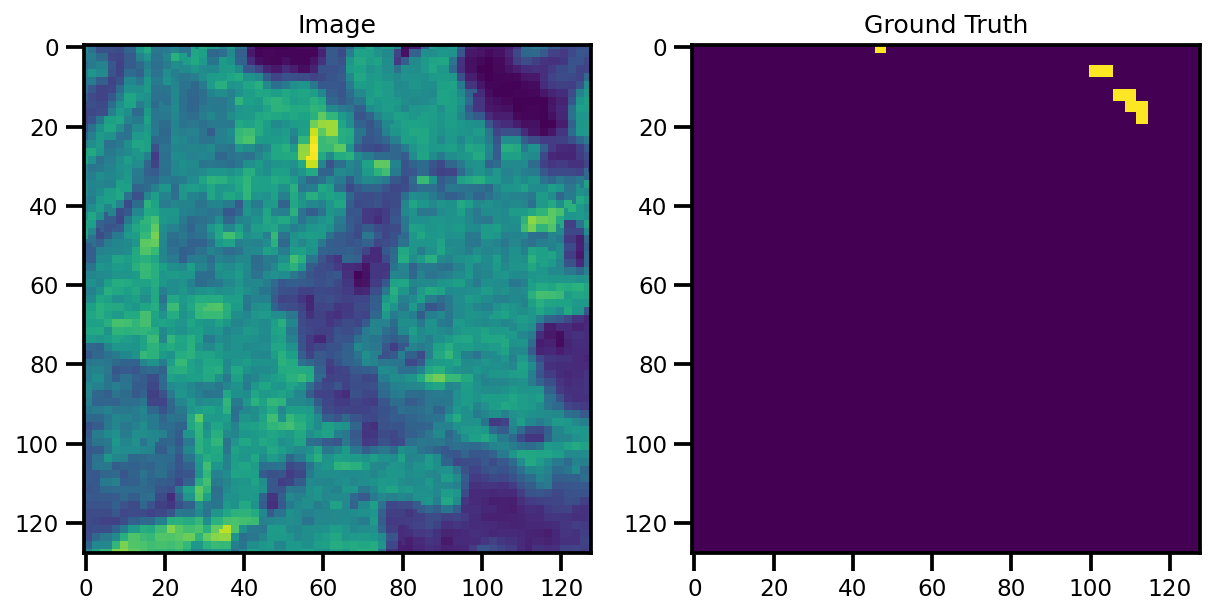

In [21]:
fig, ax = plt.subplots(figsize=(10, 10), ncols=2)

ax[0].imshow(x[6,:,:].squeeze())
ax[0].set_title("Image")

ax[1].imshow(y.squeeze())
ax[1].set_title("Ground Truth")

plt.show()

### Tiles

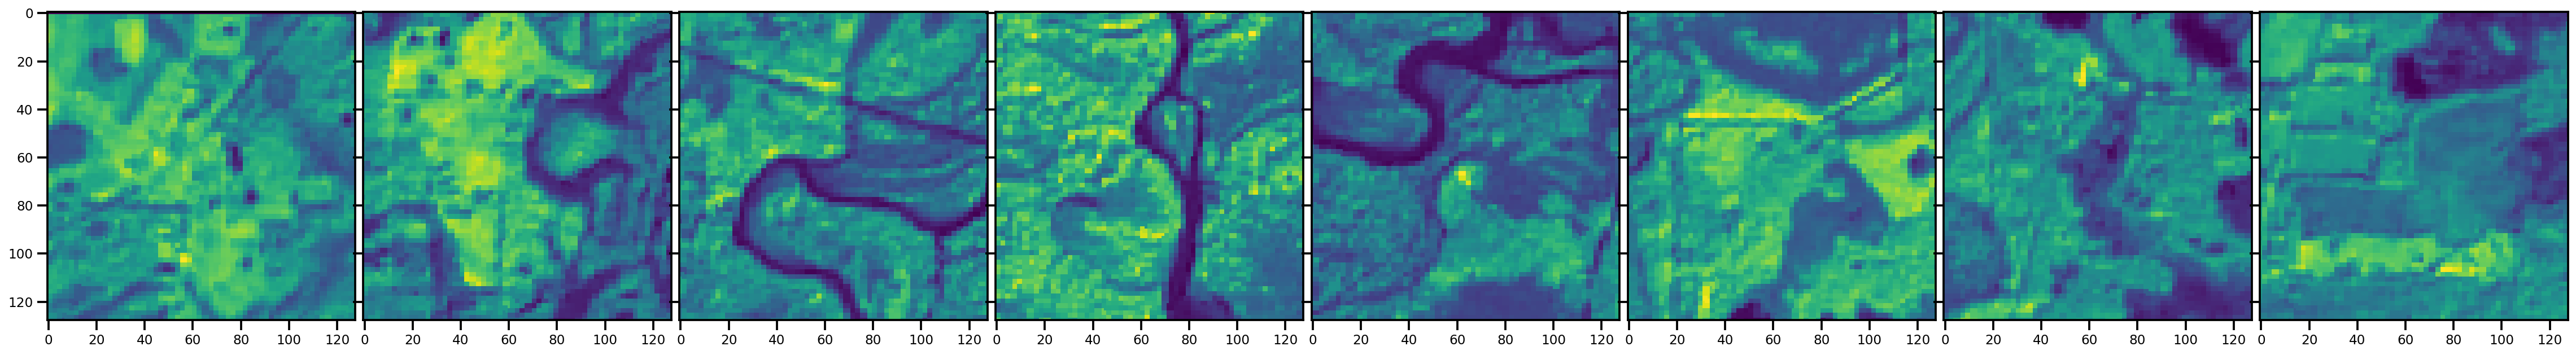

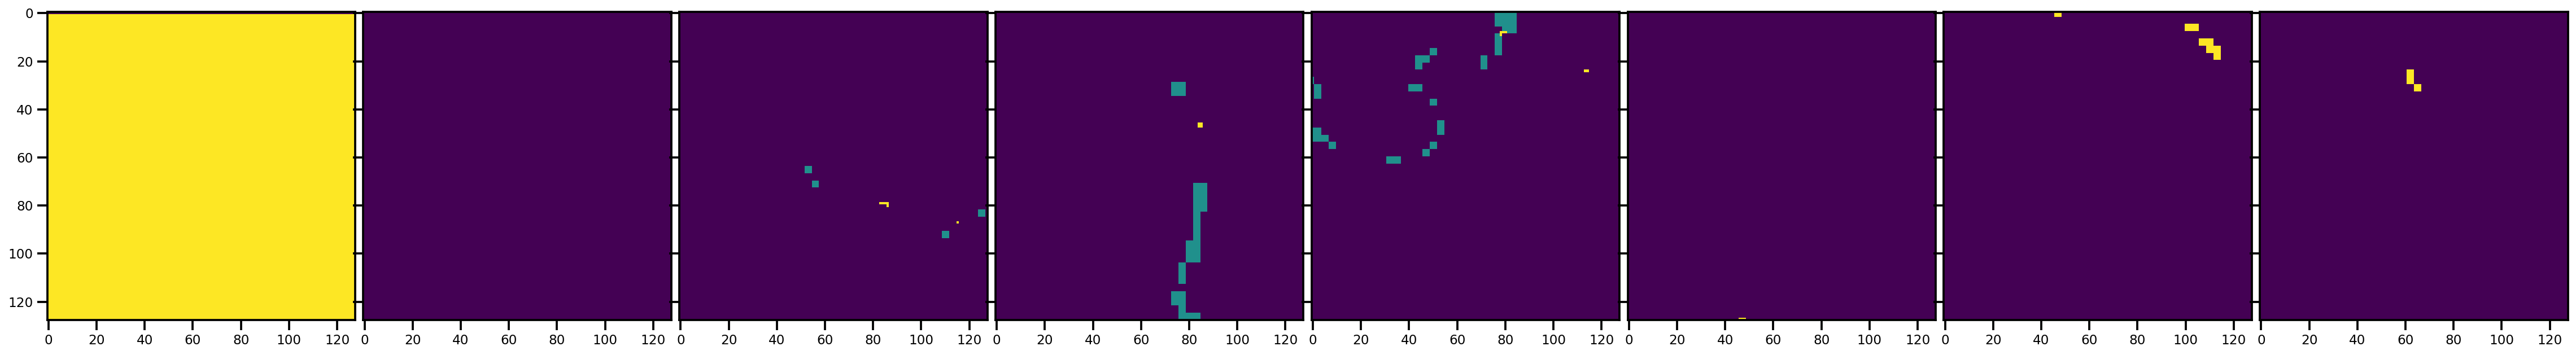

In [41]:
from rasterio.plot import show as rasterio_show
from mpl_toolkits.axes_grid1 import ImageGrid

n_tiles = 16
n_rows = 2
tiles_per_row = int(n_tiles / n_rows)
iteration = 0

# plot preamble
fig = plt.figure(figsize=(40, 20))
grid = ImageGrid(
    fig, 111,
    nrows_ncols=(1, tiles_per_row),
    axes_pad=0.1,
)




# BANDS
bands = [6,] #CHANNELS_CONFIGURATIONS["all"]

for iax, itile in zip(grid, range(n_tiles)):
    
    tile_data = train_dataset[itile]
#     print(tile_data["image"].shape, tile_data["mask"].shape)
#     print()
#     if itile < 8:
    iax.imshow(tile_data["image"][6,:,:].squeeze())
#         rasterio_show(tile_data["image"][6,:,:], ax=iax, cmap="pink")
#     else:
# #         rasterio_show(tile_data["mask"], ax=iax, cmap="pink")
#         iax.imshow(tile_data["mask"][0,:,:].squeeze())
plt.show()
    
n_tiles = 16
n_rows = 2
tiles_per_row = int(n_tiles / n_rows)
iteration = 0

# plot preamble
fig = plt.figure(figsize=(40, 20))
grid = ImageGrid(
    fig, 111,
    nrows_ncols=(1, tiles_per_row),
    axes_pad=0.1,
)




# BANDS
bands = [6,] #CHANNELS_CONFIGURATIONS["all"]

for iax, itile in zip(grid, range(n_tiles)):
    
    tile_data = train_dataset[itile]
#     print(tile_data["image"].shape, tile_data["mask"].shape)
    iax.imshow(tile_data["mask"][0,:,:].squeeze())
#  
plt.show()

### Demo